In [5]:
import numpy as np
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from numpy import genfromtxt
from keras import backend as K
K.set_image_data_format('channels_first')
from keras.models import Model,Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.core import Lambda, Flatten, Dense


In [9]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    print("Inside triplet loss")
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    print(anchor)
    print(positive)
    print(negative)
    ### START CODE HERE ### (˜ 4 lines)
    # Step 1: Compute the (encoding) distance between the anchor and the positive, you will need to sum over axis=-1
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),axis=-1)
    # Step 2: Compute the (encoding) distance between the anchor and the negative, you will need to sum over axis=-1
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),axis=-1)
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist,neg_dist),alpha)
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
    ### END CODE HERE ###
    
    print("Entering the function")
    return loss


In [10]:
def faceRecoModel(input_shape):
    """
    Implementation of the Inception model used for FaceNet
    
    Arguments:
    input_shape -- shape of the images of the dataset
    Returns:
    model -- a Model() instance in Keras
    """
        
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # First Block
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1')(X)
    X = BatchNormalization(axis = 1, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D((3, 3), strides = 2)(X)
    
    # Second Block
    X = Conv2D(64, (1, 1), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)

    # Second Block
    X = Conv2D(192, (3, 3), strides = (1, 1), name = 'conv3')(X)
    X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)
    
    X = MaxPooling2D(pool_size = 3, strides = 2)(X)
    
    X = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), data_format='channels_first')(X)
    X = Flatten()(X)
    X = Dense(128, name='dense_layer')(X)
    
    # L2 normalization
    X = Lambda(lambda  x: K.l2_normalize(x,axis=1))(X)
    
             
    # Create model instance
    model = Model(inputs = X_input, outputs = X, name='FaceRecoModel')
        
    return model

In [11]:
_FLOATX = 'float32'
def variable(value, dtype=_FLOATX, name=None):
    v = tf.Variable(np.asarray(value, dtype=dtype), name=name)
    _get_session().run(v.initializer)
    return v

def shape(x):
    return x.get_shape()

def square(x):
    return tf.square(x)

def zeros(shape, dtype=_FLOATX, name=None):
    return variable(np.zeros(shape), dtype, name)

def concatenate(tensors, axis=-1):
    if axis < 0:
        axis = axis % len(tensors[0].get_shape())
    return tf.concat(axis, tensors)

def LRN2D(x):
    return tf.nn.lrn(x, alpha=1e-4, beta=0.75)

def conv2d_bn(x,
              layer=None,
              cv1_out=None,
              cv1_filter=(1, 1),
              cv1_strides=(1, 1),
              cv2_out=None,
              cv2_filter=(3, 3),
              cv2_strides=(1, 1),
              padding=None):
    num = '' if cv2_out == None else '1'
    tensor = Conv2D(cv1_out, cv1_filter, strides=cv1_strides, data_format='channels_first', name=layer+'_conv'+num)(x)
    tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+num)(tensor)
    tensor = Activation('relu')(tensor)
    if padding == None:
        return tensor
    tensor = ZeroPadding2D(padding=padding, data_format='channels_first')(tensor)
    if cv2_out == None:
        return tensor
    tensor = Conv2D(cv2_out, cv2_filter, strides=cv2_strides, data_format='channels_first', name=layer+'_conv'+'2')(tensor)
    tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+'2')(tensor)
    tensor = Activation('relu')(tensor)
    return tensor

WEIGHTS_mod = [
  'conv1', 'bn1', 'conv2', 'bn2', 'conv3', 'bn3'
]
conv_shape = {
  'conv1': [64, 3, 7, 7],
  'conv2': [64, 64, 1, 1],
  'conv3': [192, 64, 3, 3]
}

def load_weights_from_FaceNet(FRmodel):
    # Load weights from csv files (which was exported from Openface torch model)
    weights = WEIGHTS_mod
    weights_dict = load_weights()

    # Set layer weights of the model
    for name in weights:
        if FRmodel.get_layer(name) != None:
            FRmodel.get_layer(name).set_weights(weights_dict[name])
        elif model.get_layer(name) != None:
            model.get_layer(name).set_weights(weights_dict[name])

def load_weights():
    # Set weights path
    dirPath = './weights'
    fileNames = filter(lambda f: not f.startswith('.'), os.listdir(dirPath))
    paths = {}
    weights_dict = {}

    for n in fileNames:
        paths[n.replace('.csv', '')] = dirPath + '/' + n

    for name in WEIGHTS_mod:
        if 'conv' in name:
            conv_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
            conv_w = np.reshape(conv_w, conv_shape[name])
            conv_w = np.transpose(conv_w, (2, 3, 1, 0))
            conv_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
            weights_dict[name] = [conv_w, conv_b]     
        elif 'bn' in name:
            bn_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
            bn_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
            bn_m = genfromtxt(paths[name + '_m'], delimiter=',', dtype=None)
            bn_v = genfromtxt(paths[name + '_v'], delimiter=',', dtype=None)
            weights_dict[name] = [bn_w, bn_b, bn_m, bn_v]
        elif 'dense' in name:
            dense_w = genfromtxt(dirPath+'/dense_w.csv', delimiter=',', dtype=None)
            dense_w = np.reshape(dense_w, (128, 736))
            dense_w = np.transpose(dense_w, (1, 0))
            dense_b = genfromtxt(dirPath+'/dense_b.csv', delimiter=',', dtype=None)
            weights_dict[name] = [dense_w, dense_b]

    return weights_dict

def img_to_encoding(image_path, model):
    img1 = cv2.imread(image_path, 1)
    img = img1[...,::-1]
    img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    flat_input=embedding.flatten()
    return embedding


In [41]:
#def train_1st_model():
    X,Y,m=load_train_data()
    data,labels=prepare_train_data(X,Y,m)

    FRmodel = faceRecoModel(input_shape=(3, 350, 350))
    FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
    FRmodel.fit(data,labels,epochs=500 )  # starts training
    score = FRmodel.evaluate(data,labels)
 #   return Smodel

Inside triplet loss
Tensor("loss_3/lambda_5_loss/strided_slice:0", shape=(128,), dtype=float32)
Tensor("loss_3/lambda_5_loss/strided_slice_1:0", shape=(128,), dtype=float32)
Tensor("loss_3/lambda_5_loss/strided_slice_2:0", shape=(128,), dtype=float32)
Entering the function


ValueError: Error when checking input: expected input_6 to have 4 dimensions, but got array with shape (32, 256)

In [42]:

#FRmodel = faceRecoModel(input_shape=(3, 350, 350))
#FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
#load_weights_from_FaceNet(FRmodel)

In [33]:
 def show_images(image_path_original,image_path_check):
    
    imageA=mpimg.imread(image_path_original)
    imageB=mpimg.imread(image_path_check)
    fig = plt.figure("Comparison")
 
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA, cmap = plt.cm.gray)
    plt.axis("off")
 
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB, cmap = plt.cm.gray)
    plt.axis("off")
 
    # show the images
    plt.show()

In [34]:
def verify(image_path_original, image_path_check, model): 
    
    encoding_original = img_to_encoding(image_path_original,model)
    encoding_check = img_to_encoding(image_path_check,model)
    
    dist = np.linalg.norm(encoding_original-encoding_check)
    dist = dist/256
    # setup the figure
    
    show_images(image_path_original,image_path_check)
    print ("Distance is " , dist)
    if dist < 1:
        print("It's similar")          
    else:
        print("It's not similar")
    

In [35]:

def verify_ml_approach(image_path_original,image_path_check):
    verify(image_path_original, image_path_check, FRmodel)
    
  

In [36]:
def load_train_data():
    dataset = np.genfromtxt("data.csv", dtype="U" ,delimiter="," )
    X = dataset[:,0:2]
    Y = dataset[:,2]
    Y= [int(i) for i in Y]
    m=len(Y)
    return X,Y,m


In [37]:
def getimagePath(name):
    return('images/'+str(name)+'.png')

In [18]:
def getSimpleModel():
    inputs=Input(shape=(256,))
    # a layer instance is callable on a tensor, and returns a tensor
    x = Dense(128, activation='relu')(inputs)
    x = Dense(64, activation='relu')(x)
    predictions = Dense(11, activation='softmax')(x)

    # This creates a model that includes
    # the Input layer and three Dense layers
    model = Model(inputs=inputs, outputs=predictions)
    return model

In [19]:
def getSeqModel():
    model = Sequential()
    model.add(Dense(64, activation='relu'))
    model.add(Dense(11, activation='softmax'))
    return model

In [38]:
def prepare_train_data(X,Y,m,classes=11):
    dat=np.zeros((1,256))
    data=np.zeros((m,256))
    labels=np.zeros((m,classes))
    row=0
    for [ori,chk] in X:
        ori_encoding=img_to_encoding(getimagePath(ori), FRmodel)
        chk_encoding=img_to_encoding(getimagePath(chk), FRmodel)
        dat=np.concatenate((ori_encoding,chk_encoding),axis=1)
        data[row,:]=dat
        labels[row,Y[row]]=1
        row=row+1  
    return data,labels

In [21]:
a=[1,2,3]
b=-1*np.array(a)
c=np.concatenate((a,b))
print(c)


[ 1  2  3 -1 -2 -3]


In [22]:
def train_2nd_model():
    X,Y,m=load_train_data()
    data,labels=prepare_train_data(X,Y,m)

    Smodel=getSimpleModel()
    Smodel.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    Smodel.fit(data,labels,epochs=500 )  # starts training
    score = Smodel.evaluate(data,labels)
    return Smodel
    

In [23]:
Smodel=train_2nd_model()

Epoch 1/500
32/32 [==============================] - 0s 15ms/step - loss: 2.3700 - acc: 0.2188
Epoch 2/500
32/32 [==============================] - 0s 93us/step - loss: 2.2218 - acc: 0.5625
Epoch 3/500
32/32 [==============================] - 0s 94us/step - loss: 2.0884 - acc: 0.5938
Epoch 4/500
32/32 [==============================] - 0s 94us/step - loss: 1.9622 - acc: 0.6250
Epoch 5/500
32/32 [==============================] - 0s 62us/step - loss: 1.8432 - acc: 0.5938
Epoch 6/500
32/32 [==============================] - 0s 94us/step - loss: 1.7401 - acc: 0.6250
Epoch 7/500
32/32 [==============================] - 0s 93us/step - loss: 1.6553 - acc: 0.6250
Epoch 8/500
32/32 [==============================] - 0s 156us/step - loss: 1.5835 - acc: 0.6562
Epoch 9/500
32/32 [==============================] - 0s 218us/step - loss: 1.5334 - acc: 0.6562
Epoch 10/500
32/32 [==============================] - 0s 93us/step - loss: 1.4942 - acc: 0.6250
Epoch 11/500
32/32 [===========================

Epoch 87/500
32/32 [==============================] - 0s 62us/step - loss: 0.7218 - acc: 0.7188
Epoch 88/500
32/32 [==============================] - 0s 125us/step - loss: 0.7149 - acc: 0.7188
Epoch 89/500
32/32 [==============================] - 0s 94us/step - loss: 0.7045 - acc: 0.7188
Epoch 90/500
32/32 [==============================] - 0s 218us/step - loss: 0.6968 - acc: 0.7500
Epoch 91/500
32/32 [==============================] - 0s 125us/step - loss: 0.6880 - acc: 0.7188
Epoch 92/500
32/32 [==============================] - 0s 125us/step - loss: 0.6829 - acc: 0.7500
Epoch 93/500
32/32 [==============================] - 0s 93us/step - loss: 0.6748 - acc: 0.7188
Epoch 94/500
32/32 [==============================] - 0s 187us/step - loss: 0.6721 - acc: 0.7500
Epoch 95/500
32/32 [==============================] - 0s 125us/step - loss: 0.6591 - acc: 0.7188
Epoch 96/500
32/32 [==============================] - 0s 93us/step - loss: 0.6529 - acc: 0.7500
Epoch 97/500
32/32 [==============

Epoch 172/500
32/32 [==============================] - 0s 156us/step - loss: 0.2226 - acc: 0.9688
Epoch 173/500
32/32 [==============================] - 0s 125us/step - loss: 0.2178 - acc: 1.0000
Epoch 174/500
32/32 [==============================] - 0s 62us/step - loss: 0.2158 - acc: 0.9688
Epoch 175/500
32/32 [==============================] - 0s 125us/step - loss: 0.2088 - acc: 0.9688
Epoch 176/500
32/32 [==============================] - 0s 125us/step - loss: 0.2059 - acc: 1.0000
Epoch 177/500
32/32 [==============================] - 0s 187us/step - loss: 0.2010 - acc: 0.9688
Epoch 178/500
32/32 [==============================] - 0s 62us/step - loss: 0.1983 - acc: 0.9688
Epoch 179/500
32/32 [==============================] - 0s 93us/step - loss: 0.1954 - acc: 0.9688
Epoch 180/500
32/32 [==============================] - 0s 156us/step - loss: 0.1929 - acc: 0.9688
Epoch 181/500
32/32 [==============================] - 0s 156us/step - loss: 0.1880 - acc: 0.9688
Epoch 182/500
32/32 [==

Epoch 257/500
32/32 [==============================] - 0s 94us/step - loss: 0.0562 - acc: 0.9688
Epoch 258/500
32/32 [==============================] - 0s 93us/step - loss: 0.0543 - acc: 0.9688
Epoch 259/500
32/32 [==============================] - 0s 94us/step - loss: 0.0524 - acc: 1.0000
Epoch 260/500
32/32 [==============================] - 0s 93us/step - loss: 0.0510 - acc: 1.0000
Epoch 261/500
32/32 [==============================] - 0s 93us/step - loss: 0.0501 - acc: 1.0000
Epoch 262/500
32/32 [==============================] - 0s 62us/step - loss: 0.0495 - acc: 1.0000
Epoch 263/500
32/32 [==============================] - 0s 93us/step - loss: 0.0490 - acc: 1.0000
Epoch 264/500
32/32 [==============================] - 0s 93us/step - loss: 0.0483 - acc: 1.0000
Epoch 265/500
32/32 [==============================] - 0s 62us/step - loss: 0.0481 - acc: 1.0000
Epoch 266/500
32/32 [==============================] - 0s 94us/step - loss: 0.0486 - acc: 0.9688
Epoch 267/500
32/32 [=========

Epoch 342/500
32/32 [==============================] - 0s 156us/step - loss: 0.0188 - acc: 1.0000
Epoch 343/500
32/32 [==============================] - 0s 94us/step - loss: 0.0193 - acc: 1.0000
Epoch 344/500
32/32 [==============================] - 0s 125us/step - loss: 0.0211 - acc: 1.0000
Epoch 345/500
32/32 [==============================] - 0s 187us/step - loss: 0.0207 - acc: 1.0000
Epoch 346/500
32/32 [==============================] - 0s 94us/step - loss: 0.0201 - acc: 1.0000
Epoch 347/500
32/32 [==============================] - 0s 93us/step - loss: 0.0183 - acc: 1.0000
Epoch 348/500
32/32 [==============================] - 0s 156us/step - loss: 0.0170 - acc: 1.0000
Epoch 349/500
32/32 [==============================] - 0s 63us/step - loss: 0.0162 - acc: 1.0000
Epoch 350/500
32/32 [==============================] - 0s 94us/step - loss: 0.0158 - acc: 1.0000
Epoch 351/500
32/32 [==============================] - 0s 156us/step - loss: 0.0154 - acc: 1.0000
Epoch 352/500
32/32 [====

Epoch 427/500
32/32 [==============================] - 0s 218us/step - loss: 0.0054 - acc: 1.0000
Epoch 428/500
32/32 [==============================] - 0s 94us/step - loss: 0.0090 - acc: 1.0000
Epoch 429/500
32/32 [==============================] - 0s 62us/step - loss: 0.0133 - acc: 1.0000
Epoch 430/500
32/32 [==============================] - 0s 93us/step - loss: 0.0093 - acc: 1.0000
Epoch 431/500
32/32 [==============================] - 0s 62us/step - loss: 0.0047 - acc: 1.0000
Epoch 432/500
32/32 [==============================] - 0s 94us/step - loss: 0.0034 - acc: 1.0000
Epoch 433/500
32/32 [==============================] - 0s 94us/step - loss: 0.0032 - acc: 1.0000
Epoch 434/500
32/32 [==============================] - 0s 156us/step - loss: 0.0032 - acc: 1.0000
Epoch 435/500
32/32 [==============================] - 0s 155us/step - loss: 0.0031 - acc: 1.0000
Epoch 436/500
32/32 [==============================] - 0s 62us/step - loss: 0.0031 - acc: 1.0000
Epoch 437/500
32/32 [======

In [26]:
 def predict(image_path_original,image_path_check,FRmodel,Smodel):
    encoding_original = img_to_encoding(image_path_original,FRmodel)
    encoding_check = img_to_encoding(image_path_check,FRmodel)
    dat=np.concatenate((encoding_original,encoding_check),axis=1)
    
    prediction = Smodel.predict_on_batch(dat)
    return prediction

In [27]:
def predict_2_models(image_path_original,image_path_check):
    show_images(image_path_original,image_path_check)
    print("Scoring...............................")
    prediction = predict(image_path_original, image_path_check, FRmodel,Smodel)
    score = np.argmax(prediction)
    print("Score of similarity is ", score)

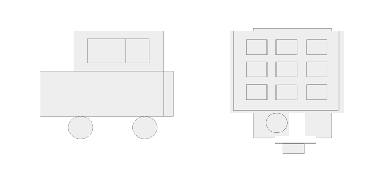

Distance is  0.0019403264159336686
It's similar


In [39]:
verify_ml_approach("images/image2.png", "images/image1_modified.png")
#predict_2_models("images/image2.png", "images/image1_modified.png")

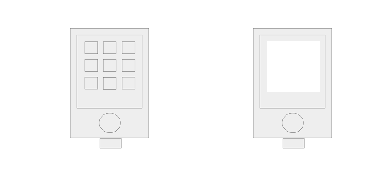

Distance is  0.0013758967397734523
It's similar


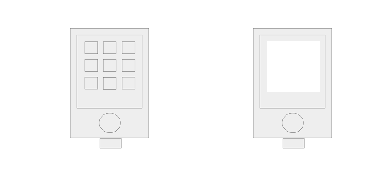

Scoring...............................
Score of similarity is  8


In [29]:
verify_ml_approach("images/image1.png", "images/image1_modified1.png")
predict_2_models("images/image1.png", "images/image1_modified1.png")

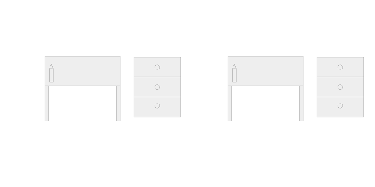

Distance is  0.0
It's similar


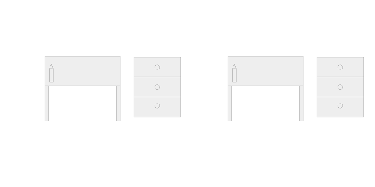

Scoring...............................
Score of similarity is  10


In [30]:
verify_ml_approach("images/image3.png", "images/image3.png")
predict_2_models("images/image3.png", "images/image3.png")

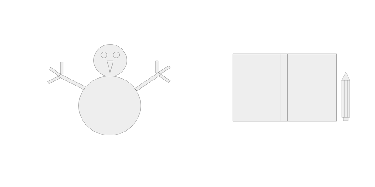

Distance is  0.0019299464765936136
It's similar


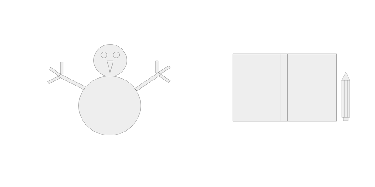

Scoring...............................
Score of similarity is  10


In [31]:
verify_ml_approach("images/image5.png", "images/image6.png")
predict_2_models("images/image5.png", "images/image6.png")